In [3]:
%matplotlib notebook
import sys
sys.path.append('./ToverBoom/')
from matplotlib import rcParams
# Set the font of the plots:
rcParams['font.family'] = 'Helvetica'
rcParams['font.sans-serif'] = ['Helvetica']
import matplotlib.pyplot as plt
import bdbplot
import bdbbio
import os
# lxml, colarama, pysam, 
import networkx as nx
import toverboom
import toverboom.lineageGraph
import toverboom.optimizeLayout
import toverboom.preprocessing
import pandas as pd
import numpy as np
import argparse
from PIL import Image
# Development:
import importlib
importlib.reload(toverboom)
importlib.reload(toverboom.lineageGraph)
importlib.reload(toverboom.preprocessing)
importlib.reload(toverboom.optimizeLayout)

<module 'toverboom.optimizeLayout' from './ToverBoom/toverboom/optimizeLayout.py'>

In [4]:
import os
def create_topfolder(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
# Load the graph file into a networkx graph
replicate = 'APKS1'
graph = nx.read_gpickle(f'./input/CNVtree/{replicate}_CNV_tree_33.pickle')


<IPython.core.display.Javascript object>


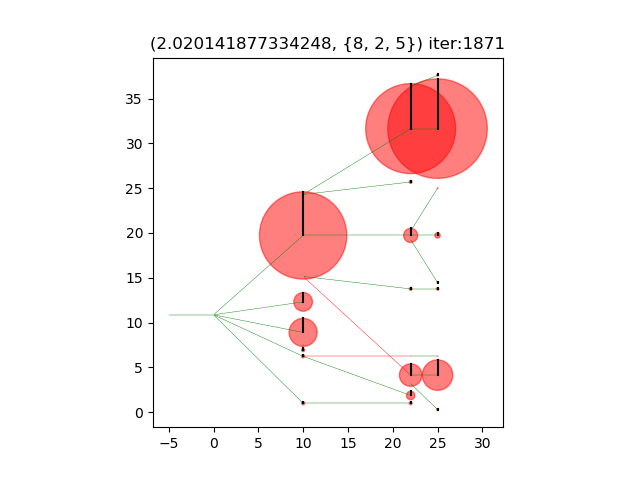

/Users/lchen/miniconda3/envs/umbrella/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [6]:
# Instantiate the lineage graph object
lg = toverboom.lineageGraph.LineageGraph(graph)

# Create a figure for our plot:
fig, ax = plt.subplots()

# Find the best layout
# return initial order
order = toverboom.optimizeLayout.optimize_layout(lg,
                                         visualize_progress_ax=ax, 
                                         visualize_progress_fig=fig, 
                                         initial_order = None) 

# APKS1: initial order = (21, 12, 30, 5, 8, 18, 1, 0, 4, 16, 9, 2, 31, 26, 3, 20)
# APKS2: initial order = (15, 6, 24, 29, 4, 10, 22, 17, 14, 33, 23, 18, 0, 32, 1, 27, 7, 28, 13, 8, 2)
# APKS3: (33,4, 12,18,27,1,17,11,14,24,29,8,0,10,13,9,25,2,31,26,19,3,15,6)
# from lg.getTrellisOrder()


<IPython.core.display.Javascript object>


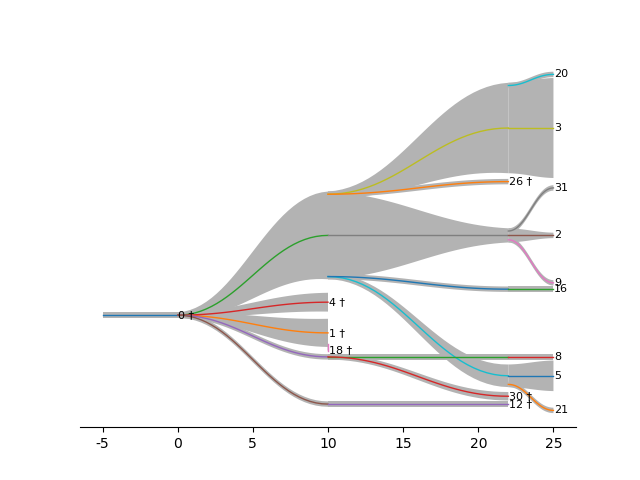

In [7]:
# Plot the polygons of the tree

fig, ax = plt.subplots()

# wavyness controls how wavy the segments of the tree are 
wavyness=0.4
# xDistance controls the stretch in the x direction 
lg.xDistance=10
lg.verticalSpacing = 0.1

lg.plotEdges(ax, bezier=True,wavyness=wavyness,stepCount=30,plotArgs={'linewidth':1}, offsetCentroid=True)
lg.plotPatches(ax=ax,wavyness=wavyness)

# Remove plot spines:
toverboom.lineageGraph.despine(ax)
# Scale labels to plot size:
toverboom.lineageGraph.format_x_axis_labels(ax)

# Add labels to the clones:
lg.annotateNodes(ax,plotArgs={'size':8})

fig.canvas.draw()

## Plot single cells on top of the tree

First construct a matrix where the single cells are described
Required columns are:
```
tp : timepoint where the cell was measured
cluster: to what cluster/clone does the cell belong
```
Optional columns are:
```
size : plotted size of the cell
marker : marker 
color  : color of the marker
```

In [8]:
def gen_imputed_matrix_for_visualization(raw_matrix, imputed_matrix, transparency = 0.45):
    '''
    raw values -> 0,1
    imputed values -> 0.45, 0.55
    return post_impute_matrix 
    = a matrix with graded values representing the evidence of values (can be even more! different round of imputation!)
    '''
    # 1. check if only include 0, 1. If -1: convert to np.nan
    raw_matrix[(raw_matrix == -1)] = np.nan
    # 2. enhance the transparency of the imputed values 
    transparent_matrix = imputed_matrix.copy()
    transparent_matrix[(transparent_matrix == 0)] = transparency
    transparent_matrix[(transparent_matrix == 1)] = (1-transparency)
    # 3. combine the measured values and imputed values in a graded matrix    
    combined_matrix = transparent_matrix.copy()
    combined_matrix.update(raw_matrix)
    
    return combined_matrix

def test_visual():
    raw = pd.DataFrame.from_dict({'col1':[0,np.nan,0,np.nan], 'col2':[1,np.nan,np.nan,1]})
    imputed = pd.DataFrame.from_dict({'col1':[0.45,0.45,0.45,0.45], 'col2':[0.55,0.55,np.nan,0.55]})
    combined = pd.DataFrame.from_dict({'col1': {0: 0.0, 1: 0.45, 2: 0.0, 3: 0.45},'col2': {0: 1.0, 1: 0.55, 2: nan, 3: 1.0}})
    
    if combined == gen_imputed_matrix_for_visualization(raw, imputed):
        pass
    else:
        raise "Error"
    return None
    

In [9]:
## Different color to show imputed sSNVs
cellData_imputed = pd.read_pickle('./input/snvMatrix/ssnvs_eight_ssnv43_selectatleast2_rfc07_imputed.pickle')
cellData_raw = pd.read_pickle("./input/snvMatrix/ssnvs_eight_version_43.pickle")
cellData_raw = cellData_raw.loc[cellData_imputed.index] 

# Combine matrices
transparent_matrix= gen_imputed_matrix_for_visualization(cellData_raw, cellData_imputed)

In [10]:
# Load example data:
cellBarcodes = pd.read_pickle('./input/cellToBarcode.pickle').loc[replicate]
cellCnv = pd.read_csv("./input/singleCellStatesWOchr1_allelic_APKSonly.csv").set_index(['Unnamed: 0','Unnamed: 1','Unnamed: 2','Unnamed: 3']).loc[replicate]
snvData= gen_imputed_matrix_for_visualization(cellData_raw, cellData_imputed).loc[replicate]
snvData = snvData.loc[cellCnv.index]


/Users/lchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


<IPython.core.display.Javascript object>


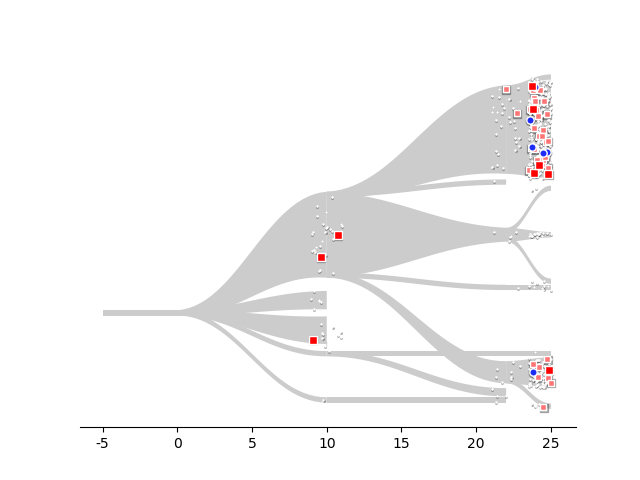

/Users/lchen/miniconda3/envs/umbrella/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [11]:
#### Contruct a dataframe with cell data
cellData = cellCnv.copy()
# Assign colors(add a new column to cellData as "color"):

# Assign passage:
cellData['tp'] = [passage for passage, plate, cell in list(cellData.index)]

# Assign sizes
# cellData['size'] = [20 if cluster==2 else 20 for cluster in cellData['cluster'] ]
# cellData['size'] = 5

i = 0
# for column in snvData.loc[list(cellCnv.index)].columns:
create_topfolder(f"./output/{replicate}")

for column in snvData.loc[list(cellCnv.index)].columns:
    
    # color snvs
    cellData['color'] = [{0:'#1d2bf7', 0.45:'#5b94ff', 
                          1:'r', 0.55:'#ff7575'}.get(cluster,'grey') for cluster in snvData[column] ]
    
    # Assign markers
    cellData['marker'] = [{0:'o', 0.45:'o', 1:'s',0.55:'s'}.get(cluster,'.') for cluster in snvData[column] ]
    
    cellData['size'] = [{0:28, 0.45:20, 
                      1:28, 0.55:20}.get(cluster,3) for cluster in snvData[column] ]

    
    # drawing order
    cellData['drawing order'] = [{1:1, 0:2, 0.55:3, 0.45:4}.get(cluster,5) for cluster in snvData[column] ]

    
    cellData.sort_values(by = 'drawing order', ascending = False, inplace = True, na_position = 'last' )
    
#     ax = plt.gca()
    fig,ax = lg.getEmptyPlot()
    lg.plotPatches(ax, facecolor=(0.8, 0.8, 0.8, 1))
    lg.plotSingleCells(cellData,ax= ax,fig= fig,  plotPatches=False,enableShadow=True)

    # Add labels to the clones:
    lg.annotateNodes(ax,plotArgs={'size':9}, 
                     # Use the nodesToAnnotate argument to select which nodes to annotate
                     nodesToAnnotate=[
                         (cluster,tp)
                          for cluster,tp in lg.graph if cluster in [1,4,3,5,2,8, 6, 7, 9, 10]],
                     x_offset = 5 # How much to move the labels to the right
                    )

    # Add vertical lines to indicate sampled timepoints
    lg.plot_vertical_lines(ax, cellData['tp'].unique(), c='black')
    
    lg.plot_xticks(ax, cellData['tp'].unique())
    
    ax.set_xlabel('Time (weeks)')
    plt.title(f"{replicate} {column[0]}:{column[1]}")
    plt.savefig(f"./output/{replicate}/{replicate}_{column[0]}_{column[1]}.png",dpi = 300)


In [12]:
# Ref: https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python
from PIL import Image
import numpy as np

def pil_grid(images, max_horiz=np.iinfo(int).max):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * ((n_images // n_horiz) + (1 if n_images % n_horiz > 0 else 0))    
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    return im_grid

In [15]:
fullpiclist = []

for root, dirs, files in os.walk(f"./output/APKS1/", topdown=True):
    for i, name in enumerate(files):
        piclist = []
        relPath = os.path.join(root, name)
        rep, snvname = name.split(sep = '_', maxsplit = 1)
        if rep[:-1] != "APKS":
            pass
        else:
            print(snvname)
            apkslist = ['APKS1','APKS2','APKS3']
            for replicate in apkslist:
                im = Image.open(f"./output/{replicate}/{replicate}_{snvname}")
                piclist.append(im)
                fullpiclist.append(im)
                combined_image = pil_grid(piclist, 3)
                create_topfolder(f"./output/combined/")
                combined_image.save(f"./output/combined/{snvname}")
full_image = pil_grid(fullpiclist, 3)
full_image.save(f"./output/combined/all_snv.png")
            

chr10_50694552.png
chr9_79094481.png
chrX_141313112.png


KeyboardInterrupt: 